## Week 12 Workshop

In this week we are continuing to work with the multi-modal model ESM-3, which can do a variety of protein design tasks. We will also again use AlphaFold 3 to predict structures.

This workshop notebook contains material from the ESM-3 tutorials, specifically [Tutorial 1](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/1_esmprotein.ipynb) and [Tutorial 3.](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/3_gfp_design.ipynb)
 
To work through all the elements of this workshop, you will need free accounts on both the ESM Forge and the AlphaFold Server:

- ESM Forge: https://forge.evolutionaryscale.ai/
- AlphaFold Server: https://alphafoldserver.com/

As always, we start by importing the dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
from biotite.structure import annotate_sse
from biotite.structure.io.pdb import PDBFile
from biotite.structure import superimpose, rmsd
from biotite.database import rcsb
from io import StringIO

import esm
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain

import py3Dmol
from getpass import getpass


## The different tracks of ESM-3



In [2]:
pdb_id = "1cm4"
chain_id = "A"

# download pdb file from RCSB
str_io = rcsb.fetch(pdb_id, "pdb")
# generate a ProteinChain object (holds the protein structure)
protein_chain = ProteinChain.from_pdb(str_io, chain_id=chain_id, id=pdb_id)
# generate an ESMProtein object (used as input for ESM-3)
protein = ESMProtein.from_protein_chain(protein_chain)


Now we can look at the protein sequence.

In [3]:
protein.sequence

'LTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMT'

We can also look at the protein structure (i.e., the coordinates of the individual atoms in the structure).

In [4]:
protein.coordinates

tensor([[[29.4900, 55.2300, 89.4950],
         [28.5830, 56.0660, 88.7360],
         [28.2720, 57.3360, 89.5170],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        [[27.5510, 58.2640, 88.8800],
         [27.1540, 59.5320, 89.4890],
         [25.6850, 59.8650, 89.2390],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        [[25.1770, 60.9740, 89.8140],
         [23.7800, 61.4010, 89.6760],
         [23.3690, 61.5970, 88.2230],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        ...,

        [[30.1690, 65.5070, 73.3640],
         [29.0820, 65.4730, 74.3330],
         [28.9170, 64.0580, 74.8810],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        [[

Residue coordinates are stored in Atom37 format, which stores 3D coordinates of up to 37 different atoms that may be found in a residue. Missing atoms are represented by missing values (`nan`). This makes it easy to handle amino acids with varying numbers of atoms in the side chain in a single tensor format. See [this paper](https://arxiv.org/abs/2507.09466) for details.

In [5]:
protein.coordinates[0]

tensor([[29.4900, 55.2300, 89.4950],
        [28.5830, 56.0660, 88.7360],
        [28.2720, 57.3360, 89.5170],
        [27.3040, 55.2730, 88.4560],
        [28.6970, 57.4970, 90.6640],
        [26.7950, 55.1210, 87.0190],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [27.8660, 54.5020, 86.1340],
        [25.5720, 54.2160, 87.0130],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
 

We can convert a `ESMProtein` into a pdb file by calling `to_pdb_string()`. Note: This only works for `ESMProtein`s that contain coordinates.

In [6]:
print(protein.to_pdb_string())

ATOM      1  N   LEU A   1      29.490  55.230  89.495  1.00  1.00           N  
ATOM      2  CA  LEU A   1      28.583  56.066  88.736  1.00  1.00           C  
ATOM      3  C   LEU A   1      28.272  57.336  89.517  1.00  1.00           C  
ATOM      4  CB  LEU A   1      27.304  55.273  88.456  1.00  1.00           C  
ATOM      5  O   LEU A   1      28.697  57.497  90.664  1.00  1.00           O  
ATOM      6  CG  LEU A   1      26.795  55.121  87.019  1.00  1.00           C  
ATOM      7  CD1 LEU A   1      27.866  54.502  86.134  1.00  1.00           C  
ATOM      8  CD2 LEU A   1      25.572  54.216  87.013  1.00  1.00           C  
ATOM      9  N   THR A   2      27.551  58.264  88.880  1.00  1.00           N  
ATOM     10  CA  THR A   2      27.154  59.532  89.489  1.00  1.00           C  
ATOM     11  C   THR A   2      25.685  59.865  89.239  1.00  1.00           C  
ATOM     12  CB  THR A   2      28.046  60.687  88.952  1.00  1.00           C  
ATOM     13  O   THR A   2  

With the pdb string, we can visualize the structure using the py3Dmol package.

In [7]:
# function to visualize a pdb string
def visualize_pdb(pdb_string):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.render()
    view.center()
    return view

visualize_pdb(protein.to_pdb_string())


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

By default, the secondary structure annotation is empty.

In [8]:
print(protein.secondary_structure)

None


We can generate secondary structure annotations from structure using the `annotate_sse()` function from biotite, and then store the information in the `ESMProtein` data structure.

In [9]:
def get_approximate_ss(protein_chain: ProteinChain):
    # get biotite's ss3 representation
    ss3_arr = annotate_sse(protein_chain.atom_array)
    biotite_ss3_str = "".join(ss3_arr)

    # translate into ESM3's representation
    translation_table = str.maketrans(
        {
            "a": "H",  # alpha helix
            "b": "E",  # beta sheet
            "c": "C",  # coil
        }
    )
    esm_ss3 = biotite_ss3_str.translate(translation_table)
    return esm_ss3

protein.secondary_structure = get_approximate_ss(protein_chain)
protein.secondary_structure

'CCHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHCCCCCCCCCCCCCCHHHHHHHHHEEEEECCCCCHHHHHHHHHHCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHHHHHHCCCCCCCCCHHHHHHHHC'

Finally, we can calculate solvent accessibilities (in Angstrom squared) from the `ProteinChain` object and store in the `ESMProtein` object. 

In [10]:
protein.sasa = protein_chain.sasa()
protein.sasa

array([113.9064126 ,  66.84046347, 151.58566976, 110.22579587,
        65.21257734,  67.05624759,  37.75985886, 104.09553798,
        28.61006296, 111.43817843,  96.7437793 ,  32.69667646,
        17.22026888,  66.13807178,  42.86836755,  46.42861262,
        18.02085274, 107.30399188, 109.57204048,  33.6287334 ,
       102.48682278,  40.30218506,  25.63876426,   2.29829866,
        36.01073039,  30.20481248, 154.88023098,  18.05886418,
        19.46794286,   0.4055821 ,  66.99336678,   9.19319528,
        38.87457792, 112.76914182,  55.49316573,  73.86329079,
        74.25680101, 115.915171  , 126.4028534 ,  24.41808629,
        72.50270122, 141.19612706,  56.56407779, 102.59139559,
        16.22328517,  81.91708083,  89.16244023,  79.9549429 ,
         9.46358287,  81.54411298, 107.39107668,  29.07180178,
        13.81817412,  70.88019848, 113.52661872,  42.83203323,
       103.6916638 ,  42.10752678,  25.24274802,   6.62450838,
        48.66805437,  52.51189262,  86.73720896,  17.24

Let's visualize the solvent accessibilities on top of the protein structure.

First we define some helper functions.

In [11]:
cmap = colormaps["cividis"]
clip_sasa_lower = 10
clip_sasa_upper = 90

def plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    _, ax = plt.subplots(figsize=(4, 0.2), dpi=450)
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    ax.text(
        0.1,
        -0.3,
        f"{clip_sasa_lower} or lower",
        va="center",
        ha="right",
        fontsize=5,
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.3,
        f"{(clip_sasa_lower + clip_sasa_upper) // 2}",
        va="center",
        ha="right",
        fontsize=5,
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.3,
        f"{clip_sasa_upper} or higher",
        va="center",
        ha="left",
        fontsize=5,
        transform=ax.transAxes,
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Functions for visualizing SASA as colors on the 3D structure
def get_color_strings(sasa, clip_sasa_lower, clip_sasa_upper, cmap):
    transformed_sasa = np.clip(sasa, clip_sasa_lower, clip_sasa_upper)
    transformed_sasa = (transformed_sasa - clip_sasa_lower) / (
        clip_sasa_upper - clip_sasa_lower
    )
    rgbas = (cmap(transformed_sasa) * 255).astype(int)

    return [f"rgb({rgba[0]},{rgba[1]},{rgba[2]})" for rgba in rgbas]

def visualize_sasa_3D_protein(
    protein, clip_sasa_lower=clip_sasa_lower, clip_sasa_upper=clip_sasa_upper, cmap=cmap
):
    pdb_string = protein.to_pdb_string()
    plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)
    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb_string, "pdb")

    for res_pos, res_color in enumerate(
        get_color_strings(protein.sasa, clip_sasa_lower, clip_sasa_upper, cmap)
    ):
        view.setStyle(
            {"chain": "A", "resi": res_pos + 1}, {"cartoon": {"color": res_color}}
        )
    view.zoomTo()
    view.render()
    view.center()

    return view

Now we generate the visualization.

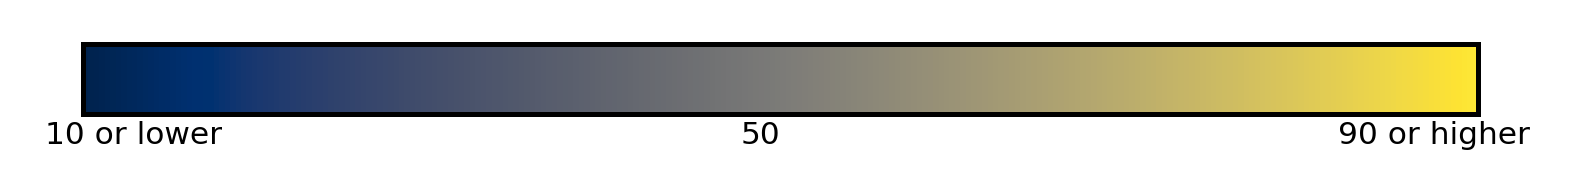

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
visualize_sasa_3D_protein(protein)

These are most of the tracks in an `ESMProtein` model, except functional annotations. Read through the [full tutorial on this topic](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/1_esmprotein.ipynb) to learn about this remaining track.

## Designing a new fluorescent protein

This part of the worksheet is based on [Tutorial 3](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/3_gfp_design.ipynb) from ESM-3. It explains how the ESM-3 team designed a new fluorescent protein using ESM-3.

The actual protein design will use the ESM Forge, as in the previous week.

The ESM Forge uses an API Key system through which you can interact from your Python scripts with their server. To generate a key, log in to your account, click on "API Keys" and create a new key. Save the key in a secure location. It is like a password.

In [13]:
# Enter your API key here. Remeber you need to keep it confidential.
# Never add your key to a github repo or post it publicly in any way.
api_key = getpass("Your EvolutionaryScale API key: ")

Now we can create the model object. Unlike in previous workshops, we are not downloading the model, we are simply connecting to the ESM Forge server.

In [14]:
model = esm.sdk.client("esm3-medium-2024-08", token=api_key)

We generate the prompt based off of PDB structure 1qy3: https://www.rcsb.org/3d-view/1QY3/1

The original workflow the ESM-3 team used was to first generate a variant backbone structure (not considering amino acid sequence) and then use inverse folding to generate a sequence on top of that structure.

We start by generating token representations for the sequence and structure of the template protein.

In [15]:
template_gfp = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("1qy3", chain_id="A")
)
template_gfp_tokens = model.encode(template_gfp)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.structure.tolist()])
)

Sequence tokens:
     0, 15, 6, 9, 9, 4, 18, 11, 6, 7, 7, 14, 12, 4, 7, 9, 4, 13, 6, 13, 7, 17, 6, 21, 15, 18, 8, 7, 8, 6, 9, 6, 9, 6, 13, 5, 11, 19, 6, 15, 4, 11, 4, 15, 18, 12, 23, 11, 11, 6, 15, 4, 14, 7, 14, 22, 14, 11, 4, 7, 11, 11, 4, 11, 19, 6, 7, 16, 23, 18, 8, 10, 19, 14, 13, 21, 20, 15, 16, 21, 13, 18, 18, 15, 8, 5, 20, 14, 9, 6, 19, 7, 16, 9, 5, 11, 12, 8, 18, 15, 13, 13, 6, 17, 19, 15, 11, 10, 5, 9, 7, 15, 18, 9, 6, 13, 11, 4, 7, 17, 10, 12, 9, 4, 15, 6, 12, 13, 18, 15, 9, 13, 6, 17, 12, 4, 6, 21, 15, 4, 9, 19, 17, 19, 17, 8, 21, 17, 7, 19, 12, 11, 5, 13, 15, 16, 15, 17, 6, 12, 15, 5, 17, 18, 15, 12, 10, 21, 17, 12, 9, 13, 6, 8, 7, 16, 4, 5, 13, 21, 19, 16, 16, 17, 11, 14, 12, 6, 13, 6, 14, 7, 4, 4, 14, 13, 17, 21, 19, 4, 8, 11, 16, 8, 5, 4, 8, 15, 13, 14, 17, 9, 15, 10, 13, 21, 20, 7, 4, 4, 9, 18, 7, 11, 5, 5, 6, 12, 2
Structure tokens:
     4098, 1025, 3124, 1129, 3227, 722, 1645, 2037, 2490, 60, 2567, 1779, 457, 2708, 383, 2219, 653, 4084, 2984, 3370, 66, 608, 2504, 103,

Now we proceed to build the detailed prompt for the backbone generation. I quote from the original tutorial:

> We'll now build a prompt. Specifically we'll specify 4 amino acid identities at positions near where we want the chromophore to form, and 2 amino acid identities on the beta barrel that are known to support chromophore formation.
>
> Furthermore we'll specify the structure should be similar to the 1qy3 structure at all these positions by adding tokens from the encoded 1qy3 structure to the structure track of our prompt. We'll also specify a few more positions (along the alpha helix kink).

In [16]:
prompt_sequence = ["_"] * len(template_gfp.sequence)
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQEATISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGI
___________________________________________________________T__TYG____________________________R_____________________________________________________________________________________________________________________________E_______
_______________________________________________________✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔_______________________✔_____________________________________________________________________________________________________________________________✔_________


In these three lines of output, we see first the original GFP sequence (which will not be used as input prompt), and then the masked sequence with only a handful of residues unmasked, as well as the masked structure track with only a handful of structure positions unmasked (shown as checkmarks).

One note about the R in position 93. From the tutorial:

> One small note, we introduced the mutation A93R in our prompt. This isn't a mistake. Using Alanine at this position causes the chromophore to mature extremely slowly (which is how we are able to measure the precyclized structure of GFP!). However we don't want to wait around for our GFPs to glow so we go with Arginine at this position.

Also, note that this prompt is very unconstrained. We only impose some amino acid and structural constraints near the part that forms the chromophore. We should not expect this prompt to easily give us backbones that look like GFP.

Next we run the generation, using the `"structure"` track only to generate a backbone but no amino acid sequence.

In [17]:
num_tokens_to_decode = min((prompt.structure == 4096).sum().item(), 20)

structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=1.0,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

These are the structure tokens corresponding to our new design:
     4098, 1708, 754, 3715, 2119, 2073, 4055, 1701, 316, 2134, 9, 588, 2703, 2134, 3056, 2874, 1967, 3942, 2874, 2082, 1770, 1421, 1035, 683, 1599, 2516, 2695, 1862, 1393, 2296, 588, 3417, 3402, 588, 1051, 112, 3806, 1476, 1051, 3117, 220, 2048, 282, 2387, 1444, 808, 490, 820, 544, 492, 1631, 1254, 2748, 3837, 2974, 1774, 732, 1797, 3372, 3403, 2370, 2582, 3704, 2737, 3007, 1660, 499, 484, 2202, 2786, 1110, 85, 2493, 1717, 270, 2227, 3726, 3254, 1416, 603, 370, 566, 2891, 3370, 1118, 588, 588, 1068, 319, 588, 2299, 3223, 4066, 1066, 2453, 2, 3997, 47, 846, 2540, 3562, 902, 2721, 2361, 860, 2149, 104, 1383, 2935, 2260, 1556, 658, 3365, 1256, 1638, 994, 443, 1439, 325, 1632, 2925, 784, 3136, 3786, 780, 1809, 257, 3869, 546, 933, 3262, 2860, 2890, 971, 561, 1329, 397, 3619, 1510, 3786, 1085, 1274, 3447, 2785, 2410, 1126, 2971, 1468, 2437, 387, 638, 2734, 91, 2420, 2721, 1962, 1534, 121, 1400, 3420, 1786, 1786, 1306, 784, 1558

We can visualize the generated structure. Chances are it will not look like a GFP.

In [18]:
view = py3Dmol.view(width=600, height=400)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In the original ESM-3 paper, they repeated this design many times until they obtained a reasonable structure. They checked this by calculating the RMSD to the template structure of both the entire backbone (which should be high, so there is some variation relative to the template) and the constrained sites (which should be low, so it is likely going to be a real GFP).

In [19]:
constrained_site_positions = [59, 62, 63, 64, 93, 219]

template_chain = template_gfp.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 5.55 Ang ❌
Backbone RMSD: 11.55 Ang ✅


Since we don't have the compute available here to repeat this process many times, we'll cheat and just build a prompt where we mask every other site of the original GFP sequence. But before we do so, we store the original prompt, as we will reuse parts of it later.

In [20]:
prompt_orig = prompt

Now we create a new prompt that copies over part of the original GFP sequence.

In [21]:
# start with the template sequence
prompt_sequence = list(template_gfp.sequence)

# mask every other position
for i in range(0, len(prompt_sequence), 2):
    prompt_sequence[i] = "_"

# set the amino acids we want in place for sure
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQEATISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGI
_G_E_F_G_V_I_V_L_G_V_G_K_S_S_E_E_D_T_G_L_L_F_C_T_K_P_P_P_L_T_LTYGV_C_S_Y_D_M_Q_D_F_S_M_E_Y_Q_R_I_F_D_G_Y_T_A_V_F_G_T_V_R_E_K_I_F_E_G_I_G_K_E_N_N_H_V_I_A_K_K_G_K_N_K_R_N_E_G_V_L_D_Y_Q_T_I_D_P_L_P_N_Y_S_Q_A_S_D_N_K_D_M_L_E_V_A_G_
_______________________________________________________✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔_______________________✔_____________________________________________________________________________________________________________________________✔_________


This is our new prompt (again, with the template sequence as the first output line). Let's generate a backbone structure for this prompt.

In [22]:
num_tokens_to_decode = min((prompt.structure == 4096).sum().item(), 20)

structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=1.0,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

These are the structure tokens corresponding to our new design:
     4098, 1333, 2234, 179, 255, 1710, 2338, 3864, 4061, 60, 1167, 1147, 1895, 3118, 2599, 2433, 2238, 4084, 2984, 3611, 1846, 128, 3254, 2112, 2339, 624, 3054, 2580, 2189, 3731, 889, 3731, 1048, 952, 291, 3759, 3833, 3015, 1128, 3445, 2302, 2149, 1151, 1482, 3239, 1988, 560, 3405, 2456, 642, 3697, 1751, 2468, 3906, 2233, 1774, 732, 1797, 3372, 3403, 2370, 2582, 3704, 2737, 3007, 1660, 499, 484, 2202, 2786, 1307, 829, 2468, 2583, 2726, 1574, 2147, 542, 4050, 1009, 932, 1132, 4000, 458, 3728, 2423, 1000, 288, 2614, 3151, 2973, 1071, 2149, 1066, 35, 3798, 1966, 1272, 2722, 882, 506, 3554, 1640, 3384, 1443, 1177, 973, 178, 3507, 986, 1668, 3168, 424, 1708, 497, 968, 1457, 3677, 1514, 2885, 1813, 1226, 1473, 1226, 1692, 2575, 1680, 903, 1151, 1161, 36, 2920, 3870, 2264, 3323, 777, 2681, 533, 612, 2462, 2273, 1403, 1160, 1181, 586, 1508, 1199, 1092, 1194, 1744, 610, 3591, 2871, 1285, 3552, 3469, 159, 2499, 583, 2420, 1674, 1175

And visualize the generated backbone structure.

In [23]:
view = py3Dmol.view(width=600, height=400)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

And again, our quality control check.

In [24]:
constrained_site_positions = [59, 62, 63, 64, 93, 219]

template_chain = template_gfp.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 2.00 Ang ❌
Backbone RMSD: 3.77 Ang ✅


Let's visualize the generated backbone superimposed on the original structure.

In [25]:
def align_and_visualize(pdb_string1, pdb_string2, chain1='A', chain2='A', highlight=None):
    structure1 = PDBFile.read(StringIO(pdb_string1)).get_structure()[0]
    structure2 = PDBFile.read(StringIO(pdb_string2)).get_structure()[0]

    # Get CA atoms for alignment
    ca1 = structure1[(structure1.chain_id == chain1) & (structure1.atom_name == 'CA')]
    ca2 = structure2[(structure2.chain_id == chain2) & (structure2.atom_name == 'CA')]
    
    # Match lengths
    n_atoms = min(len(ca1), len(ca2))
    ca1 = ca1[:n_atoms]
    ca2 = ca2[:n_atoms]
    
    # Superimpose CA atoms to get transformation
    ca2_aligned, transformation = superimpose(ca1, ca2)
    
    # Apply transformation to full structure
    structure2_aligned = structure2.copy()
    structure2_aligned.coord = transformation.apply(structure2.coord)
    
    # Print alignment info
    print(f"RMSD: {rmsd(ca1, ca2_aligned):.2f} Å ({n_atoms} CA atoms)")
    
    # Convert to PDB format for visualization
    pdb1 = StringIO()
    pdb_file1 = PDBFile()
    pdb_file1.set_structure(structure1)
    pdb_file1.write(pdb1)
    
    pdb2 = StringIO()
    pdb_file2 = PDBFile()
    pdb_file2.set_structure(structure2_aligned)
    pdb_file2.write(pdb2)
    
    # Visualize
    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb1.getvalue(), 'pdb')
    view.addModel(pdb2.getvalue(), 'pdb')
    view.setStyle({'model': 0}, {'cartoon': {'color': 'lightblue', 'opacity': .8}})
    view.setStyle({'model': 1}, {'cartoon': {'color': 'khaki'}})
    if highlight is not None:
        view.setStyle({'model': 1, 'resi': highlight}, {'cartoon': {'color': 'tomato'}})
    view.zoomTo()
    
    return view

view = align_and_visualize(
    template_chain.to_pdb_string(),   # original structure
    generation_chain.to_pdb_string()  # rebuilt structure
)
view.show()

RMSD: 6.17 Å (227 CA atoms)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Now we generate a sequence onto the generated structure. But when doing so, we need to make sure whe have a (mostly) empty sequence prompt. This is where the original prompt we stores comes back into play. We copy the sequence portion of it over to the prompt we're using here.

In [26]:
# copy over the original sequence, which is mostly empty
structure_generation.sequence = prompt_orig.sequence

# number of decoding steps; according to ESM, there isn't much benefit
# to iterative decoding past 20 steps
num_tokens_to_decode = min((structure_generation.sequence == 32).sum().item(), 20)

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

After we have generated a sequence, we refold it one more time so we have both a sequence and a structure for the generated protein.

In [27]:
# Refold
sequence_generation.structure = None
#length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=1, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

This is our final generated sequence.

In [28]:
sequence_generation_protein.sequence

'AGASDFTGAKNITVTLNANVNGTKFSLSGSGTGNSDTGTLNLTFSATSGTAPNLGLYIGTITTYGLPFTKCANATTCKYNPFKAAFPEGYTVTRTITYEDGEVINATAVVKFSGSTIVSDITLVGTGGPANGPIYGAGAVLKPTQSVTYPFTSLGSNGFKTVNNMKAEFTNGIVVNFTSNTVVTKIGSTAMSIPANGSVSHDFTNNIDANGNATTLTLNETLVFSGN'

Let's look at an alignment between the original and the designed sequence. Green sites are identical to the original. We want a good proportion of white sites to make sure we have a new design.

Sequence identity: 30.30%

Sequence alignment:


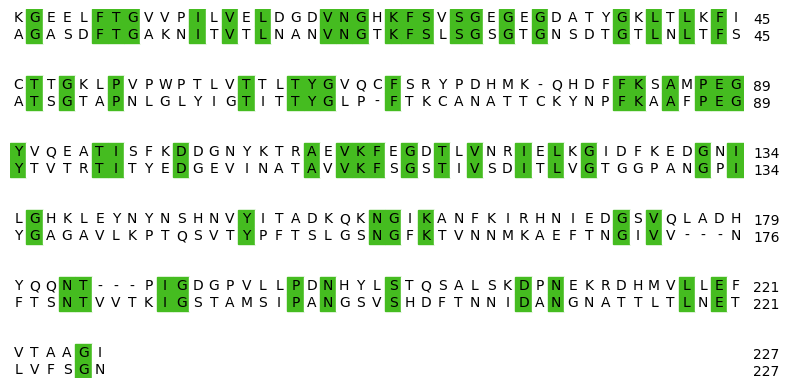

In [29]:
seq1 = seq.ProteinSequence(template_gfp.sequence)
seq2 = seq.ProteinSequence(sequence_generation_protein.sequence)

alignments = align.align_optimal(
    seq1, seq2, align.SubstitutionMatrix.std_protein_matrix(), gap_penalty=(-10, -1)
)

alignment = alignments[0]

identity = align.get_sequence_identity(alignment)
print(f"Sequence identity: {100*identity:.2f}%")

print("\nSequence alignment:")
fig = plt.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=45, spacing=2, show_numbers=True
)
fig.tight_layout()
plt.show()

We check the quality metrics of the designed protein one more time.

In [30]:
template_chain = template_gfp.to_protein_chain()
generation_chain = sequence_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "🤷‍♂️"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 1.72 Ang ❌
Backbone RMSD: 2.13 Ang 🤷‍♂️


And visualize the generated structure compared to the original structure one more time.

In [31]:
view = align_and_visualize(
    template_chain.to_pdb_string(),   # original structure
    generation_chain.to_pdb_string()  # rebuilt structure
)
view.show()

RMSD: 3.42 Å (227 CA atoms)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Exercises

- Compare the structure produced by ESM-3 for the designed sequence to the structure AlphaFold predicts for the same sequence.

- Try different prompts, masking larger or smaller amounts of the original sequence.

- Try building a GFP from the GFP secondary structure and solvent accessibility.
 